In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import imageio.v3 as iio
import open3d as o3d
import pandas as pd
import os
import cv2 as cv

In [2]:
# load camera intrinsics from csv
data_path = "iphone_vid_2"
def depth_to_point_cloud(depth_im, fx, fy, cx, cy):
    rows, cols = depth_im.shape
    x = np.arange(0, cols)
    y = np.arange(0, rows)
    xx, yy = np.meshgrid(x, y)
    X = (xx - cx) * depth_im / fx
    Y = (yy - cy) * depth_im / fy
    Z = depth_im
    return np.stack([X, Y, Z], axis=-1)

def get_intrinsics_from_csv(data_path):
    intrinsics = pd.read_csv(os.path.join(data_path, "camera_matrix.csv"))
    intrinsics_header = intrinsics.columns
    header_np = np.array(intrinsics_header)
    header_np = np.array([float(header_np[0]), float(header_np[1]), float(header_np[2])])
    header_np = header_np[np.newaxis, :]
    intrinsics_np = intrinsics.to_numpy()
    intrinsics = np.concatenate((header_np, intrinsics_np), axis=0)
    return intrinsics



intrinsics = get_intrinsics_from_csv(data_path)

# save intrinsics as numpy
np.save(os.path.join(data_path, "intrinsics_iphone.npy"), intrinsics)

In [3]:
# load mp4 file using opencv
cap = cv.VideoCapture(os.path.join(data_path, "rgb.mp4"))
rgb_frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    rgb_frames.append(frame[:, :, ::-1])
cap.release()




In [4]:
scale_rgb = True
rgb_frames = np.array(rgb_frames)
no_frames = rgb_frames.shape[0]
depth_frames = []
# load depth from 000000.png to 000no_frames.png
for i in range(no_frames):
    depth_frame = cv.imread(os.path.join(data_path, "depth", f"{i:06d}.png"), cv.IMREAD_UNCHANGED)
    # scale depth frame size to rgb frame size
    if not scale_rgb:   
        depth_frame = cv.resize(depth_frame, (rgb_frames[i].shape[1], rgb_frames[i].shape[0]))
    depth_frames.append(depth_frame)
depth_frames = np.array(depth_frames)

if scale_rgb:
    scaling_factor_down = depth_frames.shape[1] / rgb_frames.shape[1]
    # resize rgb to depth size
    rgb_frames_resized = []
    for i in range(no_frames):
        rgb_frames_resized.append(cv.resize(rgb_frames[i], (depth_frames[i].shape[1], depth_frames[i].shape[0])))
    rgb_frames = np.array(rgb_frames_resized)

    intrinsics[0, :] *= scaling_factor_down
    intrinsics[1, :] *= scaling_factor_down

    np.save(os.path.join(data_path, "intrinsics_iphone.npy"), intrinsics)


In [5]:
print("size of rgb frames: ", rgb_frames.shape)
print("size of depth frames: ", depth_frames.shape)
# save rgb and depth
np.save(os.path.join(data_path, "rgb.npy"), rgb_frames)
np.save(os.path.join(data_path, "depth.npy"), depth_frames)


size of rgb frames:  (704, 192, 256, 3)
size of depth frames:  (704, 192, 256)


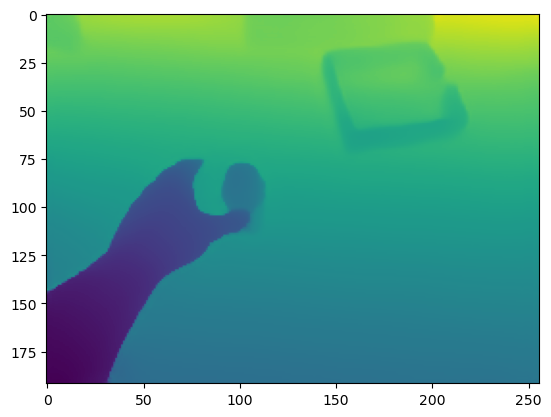

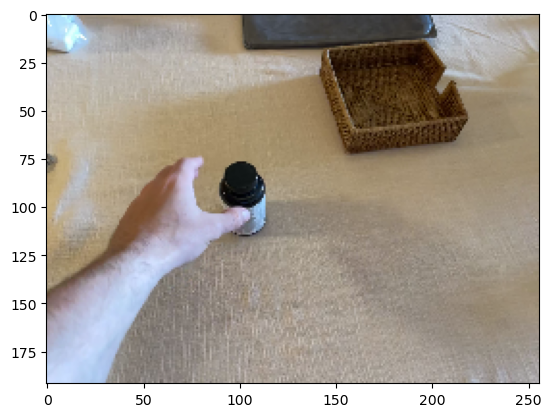

In [6]:
plt.imshow(depth_frames[50][..., np.newaxis  ])
plt.show()
plt.imshow(rgb_frames[50])
plt.show()

In [7]:
points_clouds = depth_to_point_cloud(depth_frames[0], intrinsics[0, 0], intrinsics[1, 1], intrinsics[0, 2], intrinsics[1, 2])
points_clouds = points_clouds.reshape(-1, 3)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_clouds)
pcd.colors = o3d.utility.Vector3dVector(rgb_frames[0].reshape(-1, 3) / 255)

o3d.visualization.draw_geometries([pcd])


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
